# Probe Training Experiment

This notebook trains a probe to predict the number of tokens remaining in a sequence from model activations.

## Overview
The probe uses logarithmic binning to classify activation vectors into bins representing different ranges of tokens remaining. This approach handles the wide range of possible values more effectively than direct regression.

## 1. Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple, Optional, Dict, Any, List
import logging
import os
from pathlib import Path
from pydantic import BaseModel
from jaxtyping import Float, Int

from pipeline.load_activations import prepare_dataloaders

## 2. Configuration & Logging Setup

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## 3. Data Models

In [4]:
class TrainingStats(BaseModel):
    """Statistics from probe training"""
    train_losses: List[float]
    test_losses: List[float]
    final_train_loss: Optional[float]
    final_test_loss: Optional[float]
    n_epochs: int
    n_bins: int
    learning_rate: float
    input_dim: int
    train_sequences: int
    test_sequences: int
    train_samples: int
    test_samples: int
    total_sequences: int

## 4. Model Architecture

In [6]:
class LogBinClassifier(nn.Module):
    """
    Classifier that predicts tokens remaining using logarithmic binning.
    
    The model bins the target values (tokens remaining) into logarithmic bins
    to handle the wide range of possible values more effectively.
    """
    
    def __init__(self, input_dim: int, n_bins: int = 11):
        """
        Args:
            input_dim: Dimension of input activations
            n_bins: Number of logarithmic bins for classification
        """
        super().__init__()
        self.n_bins = n_bins
        self.linear = nn.Linear(input_dim, n_bins, dtype=torch.bfloat16)

    def forward(self, x: Float[torch.Tensor, "batch d_model"]) -> Float[torch.Tensor, "batch n_bins"]:
        return self.linear(x)

In [7]:
class SimpleLinearProbe(nn.Module):    
    def __init__(self, input_dim: int):
        """
        Args:
            input_dim: Dimension of input activations
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, dtype=torch.bfloat16)
    
    def forward(self, x: Float[torch.Tensor, "batch d_model"]) -> Float[torch.Tensor, "batch 1"]:
        return self.linear(x).squeeze(-1)

## 5. Helper Functions

### 5.1 Binning Function

In [8]:
def bin_targets(y: Int[torch.Tensor, "batch"], n_bins: int = 11) -> Int[torch.Tensor, "batch"]:
    """
    Convert continuous target values to logarithmic bins using natural log (base e).
    
    Binning formula: floor(ln(y + 1)), clamped to [0, n_bins - 1]
    
    Args:
        y: Target values (tokens remaining)
        n_bins: Number of bins to use
        
    Returns:
        Binned target values as long tensor
    """
    return (y + 1).log().floor().clamp(0, n_bins - 1).to('cuda', dtype=torch.long)

### 5.2 Class Weight Calculation

In [9]:
def calculate_class_weights(train_dataloader: DataLoader, n_bins: int = 11) -> Float[torch.Tensor, "n_bins"]:
    """
    Calculate inverse frequency weights for class balancing.
    
    Args:
        train_dataloader: Training data loader
        n_bins: Number of bins
        
    Returns:
        Weight tensor for loss function
    """
    logger.info("Calculating class weights for balanced training")
    
    class_counts = torch.zeros(n_bins)
    total_samples = 0

    for X, y, _ in train_dataloader:
        y_binned = bin_targets(y, n_bins)
        for i in range(n_bins):
            class_counts[i] += (y_binned == i).sum().item()
        total_samples += len(y)

    # Calculate inverse frequency weights
    weight = total_samples / (n_bins * class_counts)
    weight = weight.to('cuda', dtype=torch.bfloat16)
    
    logger.info(f"Class frequencies: {class_counts}")
    logger.info(f"Class weights: {weight}")
    
    return weight

## 6. Training Configuration

Set the hyperparameters for training:

In [45]:
# Configuration parameters
ACTIVATIONS_DIR = '/workspace/llm-progress-monitor/rollouts-big/activations'
START_IDX = 0
END_IDX = None  # Use all available data
LAYER_IDX = None  # Use layer 0 by default
TEST_SIZE = 0.2
BATCH_SIZE = 2560
N_BINS = 11
LEARNING_RATE = 0.01
N_EPOCHS = 1
SAVE_PATH = '/root/llm-progress-monitor/models/probe_weights.pt'
RANDOM_STATE = 42

## 7. Load Data

Prepare the dataloaders from saved activations:

In [15]:
logger.info("Loading activations and preparing dataloaders")

train_dataloader, test_dataloader, data_stats = prepare_dataloaders(
    activations_dir=ACTIVATIONS_DIR,
    start_idx=START_IDX,
    end_idx=END_IDX,
    layer_idx=LAYER_IDX,
    test_size=TEST_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_state=RANDOM_STATE
)

logger.info(f"Data statistics: {data_stats}")

2025-10-04 20:24:15,374 - INFO - Loading activations and preparing dataloaders
2025-10-04 20:24:15,391 - INFO - Loading activations from: /workspace/llm-progress-monitor/rollouts-big/activations
2025-10-04 20:24:15,391 - INFO - Loading activations from: /workspace/llm-progress-monitor/rollouts-big/activations
2025-10-04 20:24:15,483 - INFO - Loading activations from index 0 to 5233
2025-10-04 20:24:15,483 - INFO - Loading activations from index 0 to 5233
2025-10-04 20:24:25,881 - INFO - Loaded 100 activations
2025-10-04 20:24:25,881 - INFO - Loaded 100 activations
2025-10-04 20:24:36,471 - INFO - Loaded 200 activations
2025-10-04 20:24:36,471 - INFO - Loaded 200 activations
2025-10-04 20:24:46,213 - INFO - Loaded 300 activations
2025-10-04 20:24:46,213 - INFO - Loaded 300 activations
2025-10-04 20:24:56,942 - INFO - Loaded 400 activations
2025-10-04 20:24:56,942 - INFO - Loaded 400 activations
2025-10-04 20:25:07,590 - INFO - Loaded 500 activations
2025-10-04 20:25:07,590 - INFO - Load

## 8. Initialize Model

Get the input dimension and create the model:

In [46]:
# Get input dimension from first batch
sample_batch = next(iter(train_dataloader))
input_dim = sample_batch[0].shape[1]  # (batch_size, d_model)

logger.info(f"Input dimension: {input_dim}")
logger.info(f"Using {N_BINS} logarithmic bins for classification")

# Initialize model
#model = LogBinClassifier(input_dim, N_BINS).to('cuda')
model = SimpleLinearProbe(input_dim).to('cuda').to(torch.bfloat16)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

logger.info(f"Model initialized: {model}")

2025-10-04 20:55:58,873 - INFO - Input dimension: 2560
2025-10-04 20:55:58,874 - INFO - Using 11 logarithmic bins for classification
2025-10-04 20:55:58,876 - INFO - Model initialized: SimpleLinearProbe(
  (linear): Linear(in_features=2560, out_features=1, bias=True)
)


## 9. Setup Loss Function

Calculate class weights and create the loss function:

In [ ]:
# Calculate class weights for balanced training
#class_weights = calculate_class_weights(train_dataloader, N_BINS)
#loss_fn = nn.CrossEntropyLoss(weight=class_weights)

LEARNING_RATE = 0.1
N_EPOCHS = 1

loss_fn = nn.MSELoss()
model = SimpleLinearProbe(input_dim).to('cuda').to(torch.bfloat16)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler: decays from 0.1 to 0.001 over the epoch
total_steps = len(train_dataloader) * N_EPOCHS
scheduler = optim.lr_scheduler.LinearLR(
    optimizer, 
    start_factor=1.0,  # Starts at LEARNING_RATE * 1.0 = 0.1
    end_factor=0.01,   # Ends at LEARNING_RATE * 0.01 = 0.001
    total_iters=total_steps
)

## 10. Training Loop

Train the model and track losses:

In [ ]:
logger.info(f"Starting training for {N_EPOCHS} epochs")
train_losses = []
test_losses = []

for epoch in range(N_EPOCHS):
    logger.info(f"Epoch {epoch + 1}/{N_EPOCHS}")
    model.train()
    
    for i, (X, y, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(X.to('cuda'))
        y = torch.log(y.to('cuda', dtype=torch.bfloat16))
        #y_binned = bin_targets(y, N_BINS)
        #loss = loss_fn(preds, y_binned)
        loss = loss_fn(preds, y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate
        train_losses.append(loss.item())
        
        # Calculate test loss periodically
        if i % 10 == 0:
            model.eval()
            test_loss_sum = 0
            test_batches = 0
            
            with torch.no_grad():
                for X_test, y_test, _ in test_dataloader:
                    preds_test = model(X_test.to('cuda'))
                    y_test = torch.log(y_test.to('cuda', dtype=torch.bfloat16))
                    #y_test_binned = bin_targets(y_test, N_BINS)
                    #test_loss = loss_fn(preds_test, y_test_binned)
                    test_loss = loss_fn(preds_test, y_test)
                    test_loss_sum += test_loss.item()
                    test_batches += 1
            
            avg_test_loss = test_loss_sum / test_batches
            test_losses.append(avg_test_loss)
            model.train()
            
            if i % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                logger.info(f"Batch {i}, Train Loss: {loss.item():.4f}, Test Loss: {avg_test_loss:.4f}, LR: {current_lr:.6f}")

logger.info("Training completed!")

2025-10-04 20:56:26,388 - INFO - Starting training for 1 epochs
2025-10-04 20:56:26,390 - INFO - Epoch 1/1
2025-10-04 20:56:27,994 - INFO - Batch 0, Train Loss: 1.6406, Test Loss: 1.9573
2025-10-04 20:56:29,677 - INFO - Batch 10, Train Loss: 0.9805, Test Loss: 0.8849
2025-10-04 20:56:31,425 - INFO - Batch 20, Train Loss: 0.8008, Test Loss: 0.8243
2025-10-04 20:56:33,506 - INFO - Batch 30, Train Loss: 0.6211, Test Loss: 0.6680
2025-10-04 20:56:35,396 - INFO - Batch 40, Train Loss: 0.5820, Test Loss: 0.6270
2025-10-04 20:56:37,332 - INFO - Batch 50, Train Loss: 0.5938, Test Loss: 0.6068
2025-10-04 20:56:39,102 - INFO - Batch 60, Train Loss: 0.5547, Test Loss: 0.5975
2025-10-04 20:56:40,971 - INFO - Batch 70, Train Loss: 0.6367, Test Loss: 0.5890
2025-10-04 20:56:42,910 - INFO - Batch 80, Train Loss: 0.5430, Test Loss: 0.5866
2025-10-04 20:56:44,887 - INFO - Batch 90, Train Loss: 0.5312, Test Loss: 0.5935
2025-10-04 20:56:46,867 - INFO - Batch 100, Train Loss: 0.5664, Test Loss: 0.5848
20

KeyboardInterrupt: 

## 11. Save Model

Save the trained model weights:

In [35]:
if SAVE_PATH:
    os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
    torch.save(model.linear.weight, SAVE_PATH)
    logger.info(f"Model weights saved to: {SAVE_PATH}")

2025-10-04 20:47:54,059 - INFO - Model weights saved to: /root/llm-progress-monitor/models/probe_weights.pt


## 12. Compile Training Statistics

In [36]:
training_stats = TrainingStats(
    train_losses=train_losses,
    test_losses=test_losses,
    final_train_loss=train_losses[-1] if train_losses else None,
    final_test_loss=test_losses[-1] if test_losses else None,
    n_epochs=N_EPOCHS,
    n_bins=N_BINS,
    learning_rate=LEARNING_RATE,
    input_dim=input_dim,
    **data_stats
)

logger.info("Training statistics compiled")
logger.info(f"Final train loss: {training_stats.final_train_loss:.4f}")
logger.info(f"Final test loss: {training_stats.final_test_loss:.4f}")
print(f"\nTraining Stats:\n{training_stats}")

2025-10-04 20:47:59,647 - INFO - Training statistics compiled
2025-10-04 20:47:59,648 - INFO - Final train loss: 1220608.0000
2025-10-04 20:47:59,649 - INFO - Final test loss: 1319422.5116



Training Stats:
train_losses=[3424256.0, 2752512.0, 2916352.0, 2818048.0, 2605056.0, 2867200.0, 2752512.0, 2473984.0, 2736128.0, 2342912.0, 2686976.0, 2392064.0, 3244032.0, 2703360.0, 2260992.0, 2441216.0, 2211840.0, 2424832.0, 2195456.0, 1916928.0, 2211840.0, 2867200.0, 2621440.0, 2441216.0, 2572288.0, 1916928.0, 2031616.0, 2228224.0, 2146304.0, 1687552.0, 2441216.0, 1916928.0, 2375680.0, 1884160.0, 2310144.0, 2007040.0, 1933312.0, 1769472.0, 2195456.0, 1933312.0, 1941504.0, 1630208.0, 2113536.0, 1826816.0, 2113536.0, 1728512.0, 2056192.0, 2072576.0, 1818624.0, 2072576.0, 1859584.0, 1622016.0, 1646592.0, 1867776.0, 2179072.0, 1769472.0, 1482752.0, 1990656.0, 1794048.0, 1654784.0, 1736704.0, 1622016.0, 1630208.0, 1343488.0, 2097152.0, 1949696.0, 1679360.0, 1884160.0, 1458176.0, 1884160.0, 1654784.0, 1908736.0, 1990656.0, 1712128.0, 2064384.0, 2064384.0, 1564672.0, 2039808.0, 1474560.0, 1810432.0, 1712128.0, 1703936.0, 1818624.0, 1736704.0, 1466368.0, 1490944.0, 1785856.0, 1638400.0, 1

## 13. Visualize Training Progress

Plot the training and test losses:

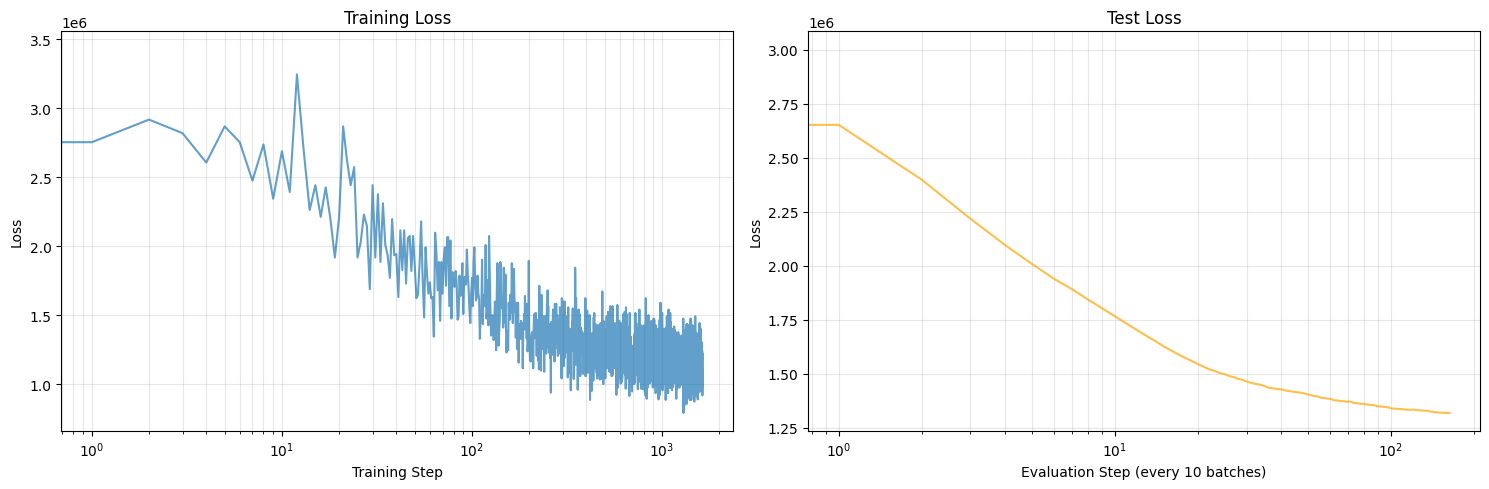


Final Training Loss: 1220608.0000
Final Test Loss: 1319422.5116


In [40]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot train losses with log scale
ax1.plot(train_losses, alpha=0.7)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3, which='both')

# Plot test losses with log scale
ax2.plot(test_losses, alpha=0.7, color='orange')
ax2.set_xlabel('Evaluation Step (every 10 batches)')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## 14. Model Evaluation

Evaluate the model on the test set:

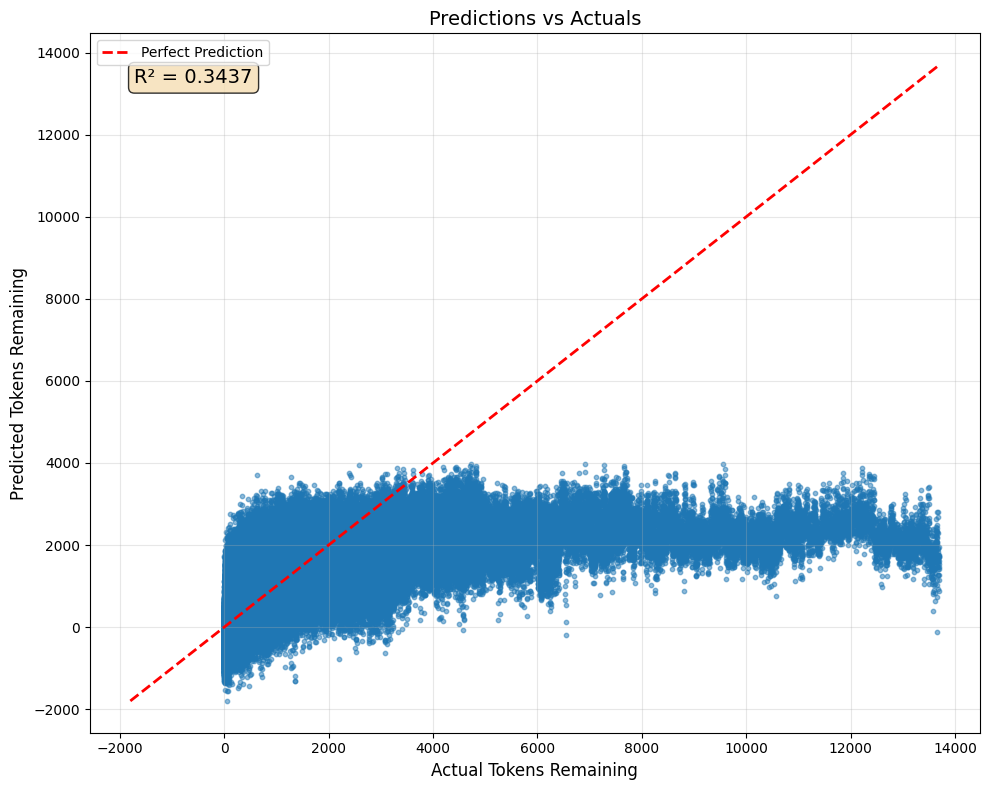


R² Score: 0.3437
Mean Absolute Error: 602.9787
Root Mean Squared Error: 1148.9250


In [43]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_test, y_test, _ in test_dataloader:
        preds_test = model(X_test.to('cuda'))
        
        predictions.extend(preds_test.cpu().float().numpy())
        actuals.extend(y_test.cpu().float().numpy())

# Convert to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate R² score
r2 = r2_score(actuals, predictions)

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(actuals, predictions, alpha=0.5, s=10)

# Add perfect prediction line
min_val = min(actuals.min(), predictions.min())
max_val = max(actuals.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Add R² score in top corner
plt.text(0.05, 0.95, f'R² = {r2:.4f}', 
         transform=plt.gca().transAxes,
         fontsize=14, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.xlabel('Actual Tokens Remaining', fontsize=12)
plt.ylabel('Predicted Tokens Remaining', fontsize=12)
plt.title('Predictions vs Actuals', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nR² Score: {r2:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(predictions - actuals)):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(np.mean((predictions - actuals)**2)):.4f}")